# Data Gathering

All data was scraped from the Akron Marathon results page, available [here](https://www.mtecresults.com/race/show/11979/2021_FirstEnergy_Akron_Marathon%252C_Half_Marathon_%2526_Team_Relay-Marathon).

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests as r

In [2]:
race_2021 = 11979
race_2019 = 8097
race_2018 = 6564
race_2017 = 5214

id_year_dict = {
    11979: 2021,
    8097: 2019,
    6564: 2018,
    5214: 2017
}

loc = 0
race = race_2021

In [3]:
def scrape_page(url):
    response = r.get(url)
    html = response.text
    soup = BeautifulSoup(html, 'lxml')
    return soup

def extract_rows_from_page(soup):
    all_rows = soup.find_all(class_='runnersearch-row')
    return all_rows
    
def extract_data_from_row(row):
    row_links = row.find_all('a')
    dataframe = pd.DataFrame({
        'Bib': [row_links[0].text],
        'Name': [row_links[1].text],
        'Sex': [row_links[2].text],
        'Age': [row_links[3].text],
        'City': [row_links[4].text],
        'State': [row_links[5].text],
        'Overall': [row_links[6].text],
        'SexPl': [row_links[7].text],
        'DivPl': [row_links[8].text],
        'Time': [row_links[9].text]
    })
    return dataframe

def scrape_one_page(race, loc):
    dataframe = pd.DataFrame(columns=['Bib','Name','Sex','Age','City','State','Overall','SexPl','DivPl','Time'])
    
    url = f"https://www.mtecresults.com/race/quickResults?raceid={race}&version=223&overall=yes&offset={loc}&perPage=500"
    soup = scrape_page(url)
    all_rows = extract_rows_from_page(soup)

    for row in all_rows:
        row = extract_data_from_row(row)
        dataframe = dataframe.append(row)
    dataframe = dataframe.reset_index(drop=True)
    return dataframe

In [4]:
df = pd.DataFrame()

for race in [race_2021, race_2019, race_2018, race_2017]:
    race_df = pd.DataFrame()
    for loc in [0, 500]:
        temp_df = scrape_one_page(race, loc)
        race_df = race_df.append(temp_df)
    race_df['RaceId'] = race
    df = df.append(race_df)

df = df.reset_index(drop=True)
df = df.astype({
    'Name':'category',
    'Sex':'category',
    'City':'category',
    'State':'category',
    'Age':float,})

df['Time'] = pd.to_datetime(df['Time']).apply(lambda x: x.time())
df['Year'] = df['RaceId'].map(id_year_dict)

# Some people participated in more than once race,
# so unique identifiers need to account for that. 
# Category dtype will categorize each unique value
df['Name'] = df['Name'].astype('category').cat.codes
df = df.rename({'Name':'PersonId'}, axis=1)

# Data Validation

To make sure the data was scraped correctly the following were checked:

1. All ages are reasonable fall in the official age division rank
1. No `NaN` or `None` values

In [5]:
df[df['Age'] < 10]

,Bib,PersonId,Sex,Age,City,State,Overall,SexPl,DivPl,Time,RaceId,Year
1344,1168,1580,M,9.0,North Canton,OH,667 / 964,460 / 611,6 / 6,05:15:04,8097,2019
2198,956,233,M,0.0,Akron,OH,557 / 883,386 / 564,,04:41:29,6564,2018
2778,3552,618,M,0.0,Mantua,OH,254 / 929,206 / 585,,04:04:00,5214,2017


There are three people with an invalid age given. They are removed because:

* No info on Facebook of their age, or the name was too common
* We have 3454 other datapoints with no missing data
* One person is labeled as 9yo, they finished the marathon so are placed in the 10-19 age division

In [6]:
df = df[df['Age'] != 0].reset_index(drop=True)

In [7]:
df.loc[1344,'Age'] = 10

Age divisions are created now that all ages are valid.

In [8]:
df['AgeDiv'] = pd.cut(
    df['Age'], 
    bins=[9,19,24,29,34,39,44,49,54,59,64,69,82], # 9 is used as divisor so that 10 is included
    precision=0
)

In [9]:
df.isna().sum()

Bib         0
PersonId    0
Sex         0
Age         0
City        0
State       0
Overall     0
SexPl       0
DivPl       0
Time        0
RaceId      0
Year        0
AgeDiv      0
dtype: int64

No `NaN` values

# Feature Engineering

Percentile rank of each participant is calculated

In [10]:
placement_df = pd.DataFrame()
for col in ['Overall', 'SexPl', 'DivPl']:
    placement = df[col].str.replace(' ','').str.split('/',expand=True)
    num = placement[0].astype(float)
    denom = placement[1].astype(float)
    
    percentile = 100 * (1-(num/denom))
    
    placement_df[f"{col}_num"] = num
    placement_df[f"{col}_denom"] = denom
    placement_df[f"{col}_percentile"] = percentile
    
    df[f'{col}Percentile'] = percentile

In [11]:
df.head()

,Bib,PersonId,Sex,Age,City,State,Overall,SexPl,DivPl,Time,RaceId,Year,AgeDiv,OverallPercentile,SexPlPercentile,DivPlPercentile
0,8,1930,M,23.0,Akron,OH,1 / 678,1 / 422,1 / 27,02:25:07,11979,2021,"(19, 24]",99.852507,99.763033,96.296296
1,3,710,M,28.0,Akron,OH,2 / 678,2 / 422,1 / 39,02:27:30,11979,2021,"(24, 29]",99.705015,99.526066,97.435897
2,2,926,M,32.0,Akron,OH,3 / 678,3 / 422,1 / 59,02:28:08,11979,2021,"(29, 34]",99.557522,99.289100,98.305085
3,5,2480,M,34.0,Uniontown,OH,4 / 678,4 / 422,2 / 59,02:39:12,11979,2021,"(29, 34]",99.410029,99.052133,96.610169
4,40,318,M,41.0,Wooster,OH,5 / 678,5 / 422,1 / 62,02:42:44,11979,2021,"(39, 44]",99.262537,98.815166,98.387097


# EDA

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Gender distribution')

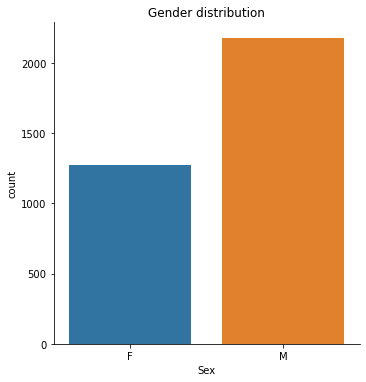

In [13]:
sns.catplot(x='Sex', data=df, kind='count')
plt.title('Gender distribution')

Text(0.5, 1.0, 'Age distribution')

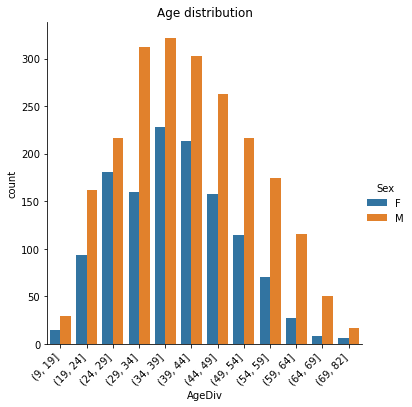

In [14]:
sns.catplot(x='AgeDiv', data=df, kind='count', hue='Sex')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Age distribution')

Male runners out number female runners at all age categories, and age distribution is a normal curve.

In [15]:
import geopandas as gpd

In [16]:
gdf = gpd.read_file('data/usa_state_geodf/tl_2021_us_state.shp')

In [17]:
person_stats = df.groupby('State').count()['PersonId'].reset_index()

In [18]:
non_cont = [
    'United States Virgin Islands',
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa',
    'Puerto Rico',
    'Guam',
    'Hawaii',
    'Alaska'
]
gdf = gdf[~gdf['NAME'].isin(non_cont)]

In [19]:
def df_to_gdf(dataframe, geo_df):
    gdf_ = geo_df.merge(dataframe, left_on='STUSPS', right_on='State', how='left').dropna(subset=['STUSPS'])
    return gdf_.reset_index(drop=True)

In [20]:
gdf_ = df_to_gdf(person_stats, gdf)
gdf_['PersonId'] = gdf_['PersonId'].fillna(0)
gdf_['came_from_here'] = gdf_['PersonId']>0

In [21]:
import matplotlib
cmap_bool = matplotlib.colors.ListedColormap(['#004c55', '#0097aa'])

Text(0.5, 1.0, 'Akron Marathon attendance')

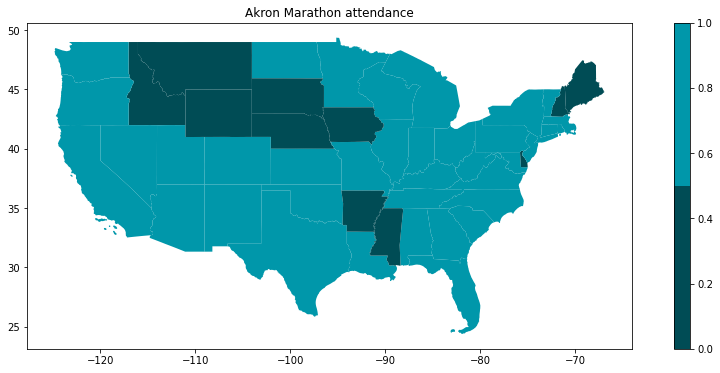

In [22]:
gdf_.plot('came_from_here', legend=True, figsize=(15,6), cmap=cmap_bool)
plt.title('Akron Marathon attendance')

Runners came from 37/48 of the continental United States

In [23]:
age_stats = df.groupby('State')['Age'].mean().round().reset_index()
gdf_ = df_to_gdf(age_stats, gdf_)

In [41]:
gdf_['person_bins'] = pd.cut(gdf_['PersonId'], bins=[0, 5, 10, 15, 50, 100, 200, 3049])

<ipython-input-42-9661f04ac5fb>:3: MatplotlibDeprecationWarning:

The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



Text(0.5, 1.0, 'Number of racers from each state')

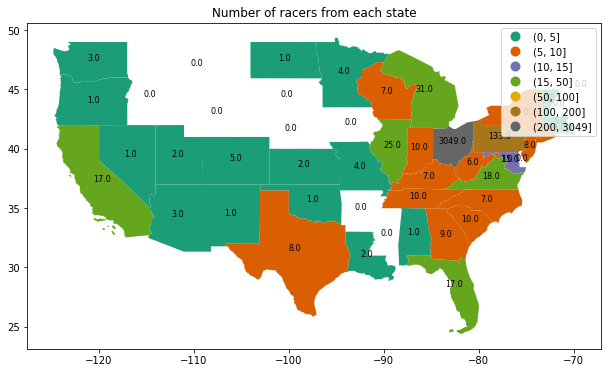

In [42]:
fig = plt.figure(1, figsize=(15,6))
ax = fig.add_subplot()
gdf_.apply(lambda x: ax.annotate(
    s=x['PersonId'],
    xy=x.geometry.centroid.coords[0],
    ha='center',
    fontsize=8), axis=1)
gdf_.plot('person_bins', legend=True, ax=ax, cmap='Dark2')
plt.title('Number of racers from each state')

In [26]:
def to_minutes(time):
    seconds = (time.hour * 60 + time.minute) * 60 + time.second
    minutes = seconds/60
    return minutes

In [27]:
df['minutes'] = df['Time'].apply(to_minutes)
df['pace'] = df['minutes']/26.2

Text(10.586927083333336, 0.5, 'Minutes per mile')

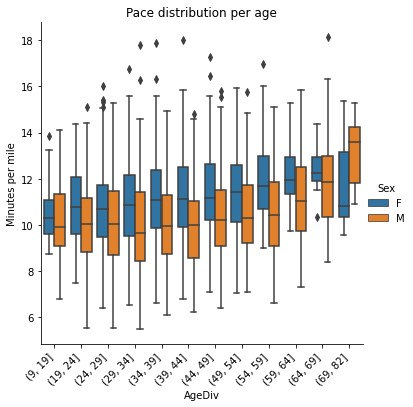

In [28]:
sns.catplot(x='AgeDiv', y='pace', data=df, kind='box', hue='Sex')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Pace distribution per age')
plt.ylabel('Minutes per mile')

Women were slower than men at all ages, except 69+ and 10-19

## With plotly

In [29]:
import plotly.express as px

In [57]:
df.head(2)

,Bib,PersonId,Sex,Age,City,State,Overall,SexPl,DivPl,Time,RaceId,Year,AgeDiv,OverallPercentile,SexPlPercentile,DivPlPercentile,minutes,pace
0,8,1930,M,23.0,Akron,OH,1 / 678,1 / 422,1 / 27,02:25:07,11979,2021,"(19, 24]",99.852507,99.763033,96.296296,145.116667,5.538804
1,3,710,M,28.0,Akron,OH,2 / 678,2 / 422,1 / 39,02:27:30,11979,2021,"(24, 29]",99.705015,99.526066,97.435897,147.500000,5.629771


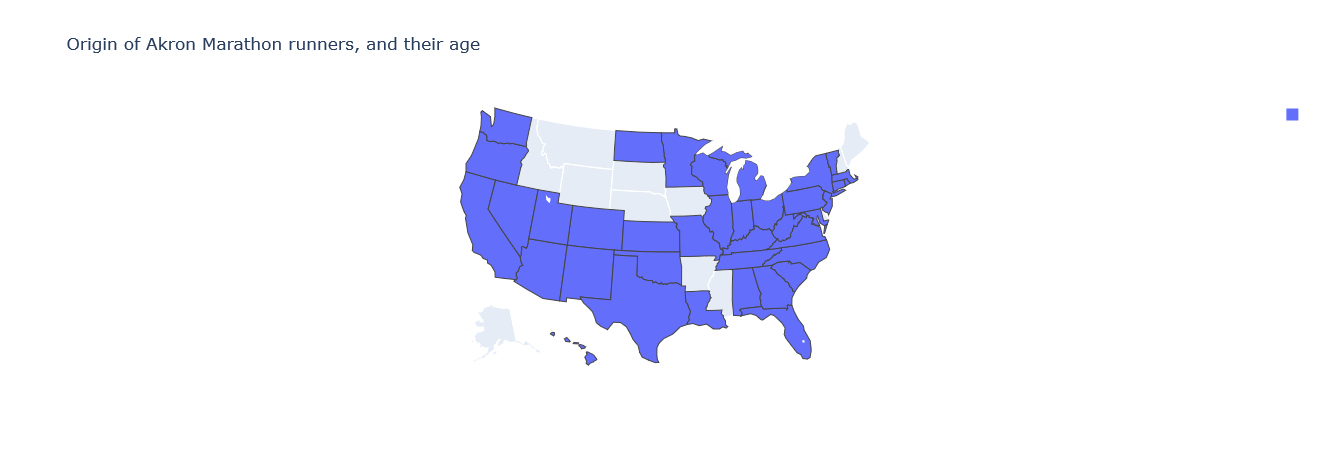

In [67]:
fig = px.choropleth(person_stats, 
                    locations=person_stats['State'], 
                    locationmode="USA-states", 
                    scope="usa",
                    title='Origin of Akron Marathon runners, and their age',
                    hover_data=['PersonId']
                    )
fig.show()